In [11]:
import numpy as np
import pandas as pd
from scipy import optimize
from numpy.linalg import norm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
from sklearn import metrics
from scipy.sparse import hstack
from pymystem3 import Mystem
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
import warnings
import random

warnings.simplefilter('ignore')
%matplotlib inline

# Функции загрузки и сохранения данных

In [31]:
def init_data(col_for_prediction = 'Price', sample_ind = 'sample'):
    data = pd.read_csv('car_data.csv', delimiter=',')
    data = data.rename(columns={"Руль": "wheel", "Привод": "drive_unit", "Владельцы": "owner", 
                                'ПТС': 'PTS', "Владение" : "own_time", "Комплектация": "Equipment"})
    data.drop_duplicates(inplace = True) 
    return data


data = init_data(col_for_prediction = 'Price', sample_ind = 'sample')

In [12]:
# Функция для загрузки подготовленных данных 
def load_func(filename='output/data_fin.zip', colname='input/columns.json'):
    data = pd.read_csv(filename)
    col_data = None
    if colname is not None:
        with open(colname) as f:
            col_data = json.load(f)

    return data, col_data   
        

# Функция для сохранения результатов расчета        
def save_func(data, col_data=None, filename='output/data_fin.zip', colname="output/columns.json"):
    data.to_csv(filename, index=False)
    if col_data is not None:
        with open(colname, "w") as f:
            f.write(json.dumps(col_data))    

        
def submission_to_csv(data, subm_ID = "", round_me = "", round_coef = 1.0, y_res_name = "", sub_file = "", 
                      subm_ID_text = "ID", subm_y_text = "Y", print_head = True):
    
    if (y_res_name == "") or (sub_file == "") or (subm_ID == ""):
        print("Не удалось сохранить в файл")
        return
    
    if round_me == "round":
        y_pred = np.round(data.query('sample == 0')[y_res_name]*round_coef)/round_coef
    elif round_me == "ceil":
        y_pred = np.ceil(data.query('sample == 0')[y_res_name]*round_coef)/round_coef
    elif round_me == "floor":
        y_pred = np.floor(data.query('sample == 0')[y_res_name]*round_coef)/round_coef
    elif round_me == "":
        y_pred = data.query('sample == 0')[y_res_name]
        
    submission = pd.DataFrame({
        subm_ID_text: data.query('sample == 0')[subm_ID],
        subm_y_text: y_pred
    })
    submission.to_csv(sub_file, index=None)
    if print_head:
        print(submission.head(3))

In [32]:
# Функция описания табличных данных (Nans, дубли, частоты значений, описательная статистика)
def data_stats_table(data, data_example=True, nlargest_num=1, stats_describe=True):
    data_stats = pd.DataFrame()

    if data_example:  # пример данных
        data_stats['data[0]'] = data.loc[0, :].T

    data_stats['dtypes'] = data.dtypes  # типы переменных
    data_stats.loc['rows_count', 'dtypes'] = len(data.dtypes)

    # расчет количества дублей
    data_stats['dupl'] = int(data.duplicated().sum())

    data_stats['NaNs'] = data.isnull().sum()  # Расчет количества NaNs
    data_stats.loc['rows_count', 'NaNs'] = (
        data.isnull().sum(axis=1) != 0).sum()
    data_stats['NaNs'] = data_stats['NaNs'].astype('int')

    # Расчет частот уникальных значений (частоты нормированы)
    for name in data.columns:
        data_stats.loc[name, 'unique'] = data[name].nunique()
        top_freq = round(data[name].value_counts(
            normalize=True).nlargest(nlargest_num), 2)
        data_stats.loc[name, 'top_freq'] = json.dumps(list(top_freq))
        data_stats.loc[name, 'top_freq_value'] = json.dumps(
            list(top_freq.index))

    if stats_describe:  # описательная статистика
        df_des = round(data.describe().T.drop(columns=['count']), 2)
        data_stats = pd.concat([data_stats, df_des], axis=1, sort=False)

    data_stats.fillna("", inplace=True)

    return data_stats


data_stats_table(data, nlargest_num = 1)

,data[0],dtypes,dupl,NaNs,unique,top_freq,top_freq_value,mean,std,min,25%,50%,75%,max
bodyType,седан,object,0,0,23,[0.39],"[""\u0432\u043d\u0435\u0434\u043e\u0440\u043e\u...",,,,,,,
brand,BMW,object,0,0,13,[0.16],"[""BMW""]",,,,,,,
color,чёрный,object,0,0,16,[0.32],"[""\u0447\u0451\u0440\u043d\u044b\u0439""]",,,,,,,
fuelType,дизель,object,0,0,5,[0.81],"[""\u0431\u0435\u043d\u0437\u0438\u043d""]",,,,,,,
modelDate,2016,float64,0,0,70,[0.08],[2010.0],2007.79,6.61,1904,2005,2009,2012,2019
name,520d 2.0d AT (190 л.с.),object,0,0,3506,[0.02],"[""1.6 AT (110 \u043b.\u0441.)""]",,,,,,,
numberOfDoors,4,float64,0,0,5,[0.56],[5.0],4.48,0.68,0,4,5,5,5
productionDate,2017,int64,0,0,73,[0.09],[2012],2009.92,6.28,1904,2007,2011,2014,2020
vehicleConfiguration,AUTOMATIC,object,0,0,4,[0.61],"[""AUTOMATIC""]",,,,,,,
engineDisplacement,2.0,object,0,0,433,[0.14],"[""2.0""]",,,,,,,


Признаки 'Equipment' и 'own_time' не будут использоваться в работе
- 'Equipment' - нет 70% данных, 
- 'own_time' - нет 70% данных

# Визуализация распределений признаков

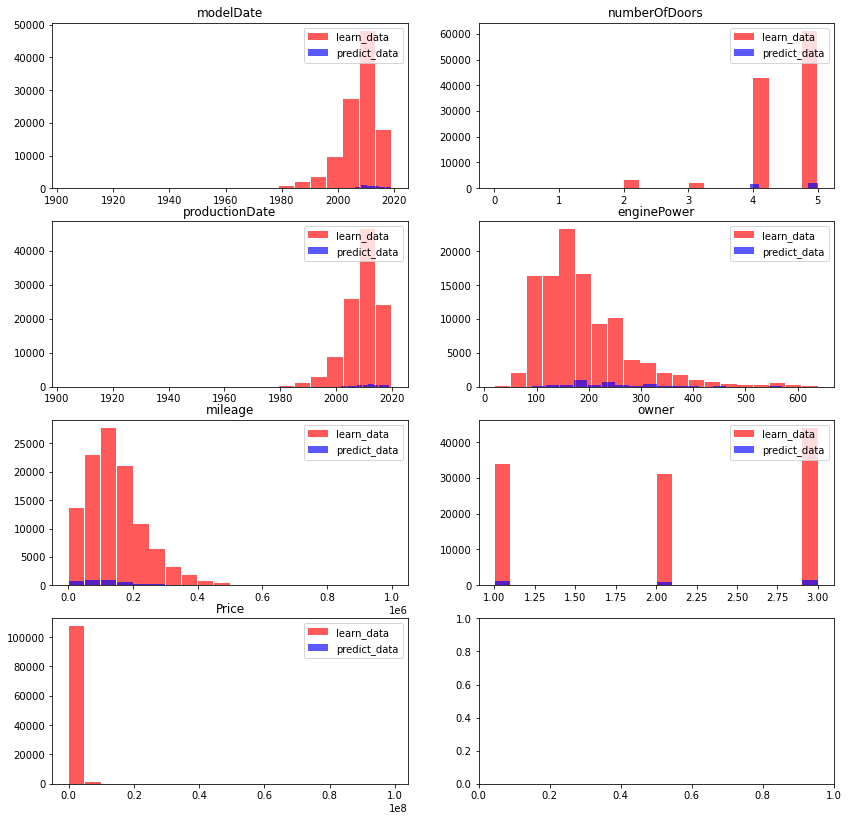

In [34]:
def plot_train_test_hist(data_, col_names, col_number=2, figsize_=(18, 8), bins_=10):
    fig, axes_ = plt.subplots(-(-len(col_names)//col_number),
                              col_number, figsize=figsize_)

    for counter_ in range(len(col_names)):
        pic_row_ = counter_//col_number
        pic_col_ = counter_ % col_number
        axes_[pic_row_, pic_col_].hist(data_[data_['sample'] == 1][col_names[counter_]], rwidth=0.95,
                                       alpha=0.65, label='learn_data', color='red', bins=bins_)

        axes_[pic_row_, pic_col_].hist(data_[data_['sample'] == 0][col_names[counter_]], rwidth=0.95,
                                       alpha=0.65, label='predict_data', color='blue', bins=bins_)

        axes_[pic_row_, pic_col_].set_title(col_names[counter_])
        axes_[pic_row_, pic_col_].legend(loc=1)


num_cols = ['modelDate', 'numberOfDoors', 'productionDate', 'enginePower', 'mileage', 'owner', 'Price']
plot_train_test_hist(data, num_cols, col_number=2, figsize_=(14, 14), bins_=20)

- Часть признаков можно логаримировать для приведения к более "нормальному" распределению

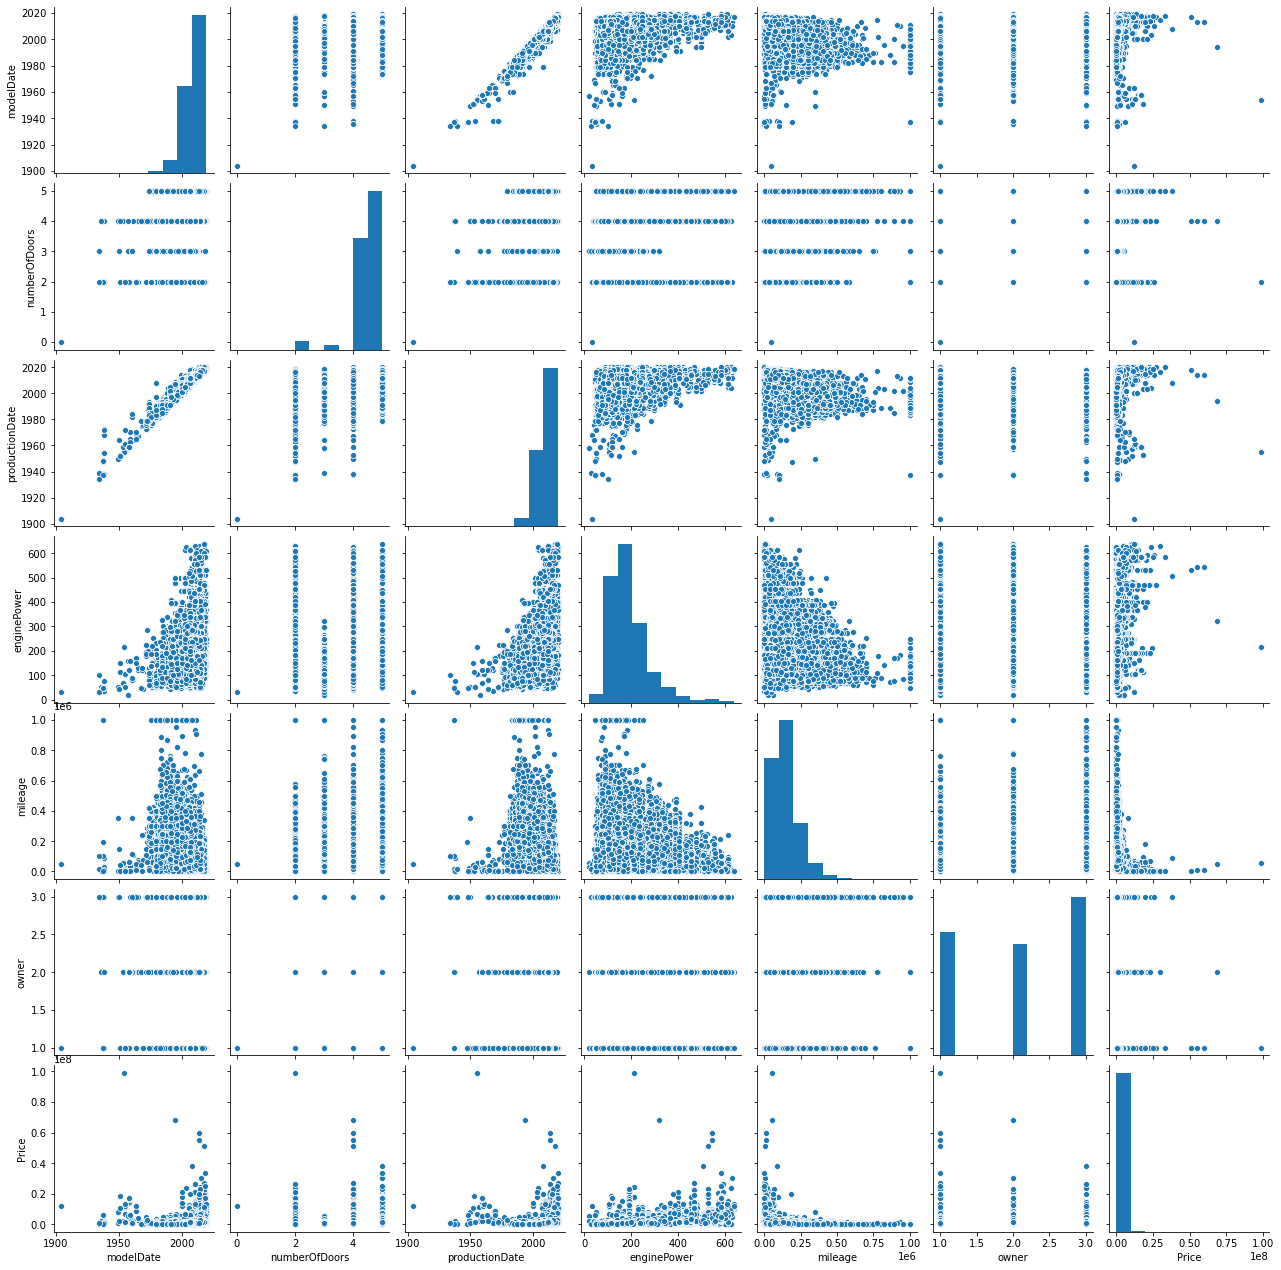

In [36]:
sns.pairplot(data[num_cols]);

# Подготовка данных

In [41]:
data['bodyType'].value_counts()

внедорожник 5 дв.          43722
седан                      41626
хэтчбек 5 дв.               7035
лифтбек                     6452
универсал 5 дв.             3716
минивэн                     2745
купе                        2318
хэтчбек 3 дв.               1312
компактвэн                  1283
пикап двойная кабина         904
купе-хардтоп                 488
внедорожник 3 дв.            477
фургон                       269
родстер                      241
кабриолет                    185
микровэн                      53
седан-хардтоп                 31
пикап полуторная кабина       15
седан 2 дв.                   13
пикап одинарная кабина         9
внедорожник открытый           7
лимузин                        6
тарга                          4
Name: bodyType, dtype: int64

In [42]:
# объеденим последние 7 значений в "other"
list_rename = data['bodyType'].value_counts()[-7:].index
data['bodyType'] = data['bodyType'].apply(lambda x: "other_body" if x in list_rename else x)

In [47]:
data['Price'] = data['Price'].apply(lambda x: np.log(x+1))

In [66]:
data['color'].value_counts()

чёрный         36625
белый          20404
серый          13073
серебристый    12892
синий          10371
коричневый      5739
красный         4487
зелёный         2446
бежевый         2170
голубой         1279
пурпурный        881
золотистый       856
фиолетовый       678
жёлтый           543
оранжевый        452
розовый           15
Name: color, dtype: int64

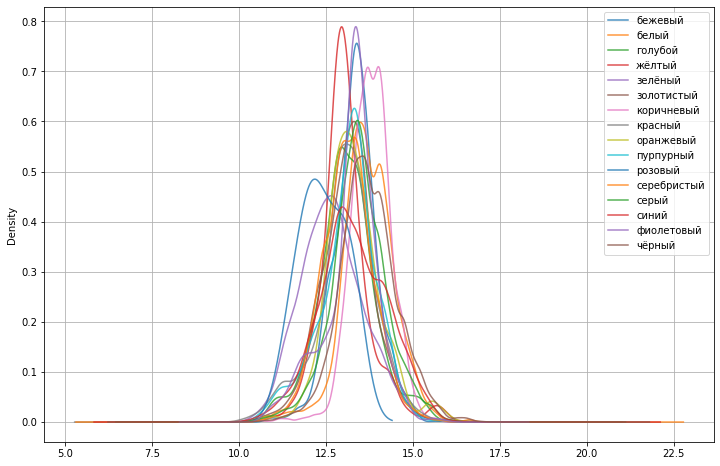

In [64]:
data[data['Price'] != 0].groupby(by = 'color')['Price'].plot(kind = 'kde', grid= True, figsize=(12,8), 
                                                             alpha = 0.8, legend = True);

In [67]:
# формально будем считать что цвет зелёный - это зелёный и розовый
data['color'] = data['color'].apply(lambda x: 'зелёный' if x == 'розовый' else x)

In [68]:
# Новый признак выделяющий AT, AMT, MT, CVT из признака name
data['name_AMT_CVT'] = "-"
for i  in [' AT ', ' MT ', ' AMT ', ' CVT ']: 
    i_ = i.replace(" ","") 
    data['name_AMT_CVT'] = data.apply(lambda x: i_ if i in x['name'] else x['name_AMT_CVT'], axis = 1)  

In [69]:
# Новый признак выделяющий объем двигателя из признака name
col_data = []
data['name_4WD'] = data['name'].str.contains('4WD').astype('int8')*2 - 1
col_data.extend(['name_4WD'])

In [70]:
# Новый признак выделяющий 4WD из признака name
def AMT_CVT_find(x):
    for i  in [' AT ', ' MT ', ' AMT ', ' CVT ']: 
        if i in x:
            x = x.replace('hyb',"")
            a = x.find(i)
            if len(x[:a])<4:
                b = x[:a]
            else:
                b = x[a-4:a]
            if b.endswith('d'):
                b = b[:-1]
            b = b.replace(" ","")
            if b == 'ctro':
                b = '2.0'
    return b

data['vol_engine'] = data['name'].apply(AMT_CVT_find)
data['vol_engine'] = data['vol_engine'].astype('float16')
col_data.extend(['vol_engine'])

In [71]:
# Новый признак выделяющий мощность из признака name 
coeff_power_to_hourse = 1.35962
data['HPower'] = data['name'].apply(lambda x: x[x.find('(')+1: x.find('л.с.')-1] 
                                    if x.find('л.с.') != -1 else x[x.find('(')+1: x.find('кВт')-1])
data['HPower'] = data['HPower'].astype('int16')
data['HPower'] = data.apply(lambda x: int(coeff_power_to_hourse*x['HPower']) 
                            if 'кВт' in x['name'] else x['HPower'], axis = 1)
data['HPower'] = data['HPower'].apply(lambda x: np.log(x+1))
col_data.extend(['HPower'])

In [72]:
# Корректировка признака numberOfDoors
data['numberOfDoors'] = data['numberOfDoors'].astype('uint8')
data['numberOfDoors'] = data['numberOfDoors'].apply(lambda x: 5 if x == 0 else x)
col_data.extend(['numberOfDoors'])

In [73]:
# Заполнение пустот максимальным значние частот
data['owner'] = data['owner'].fillna(3)
data['owner'] = data['owner'].astype('uint8')
col_data.extend(['owner'])

In [74]:
# Формирование признака разницы дат
data['modelDate'] = data['modelDate'].max() - data['modelDate']
data['productionDate'] = data['productionDate'].max() - data['productionDate']
data['DeltaDate'] = data['modelDate'] - data['productionDate']   

data['modelDate'] = data['modelDate'].apply(lambda x: np.log(x+1))
data['productionDate'] = data['productionDate'].apply(lambda x: np.log(x+1))
col_data.extend(['modelDate', 'productionDate', 'DeltaDate'])  

In [77]:
# логарифмирование признаков
data['enginePower'] = data['enginePower'].apply(lambda x: np.log(x+1))
col_data.extend(['enginePower'])

data['mileage'] = data['mileage'].apply(lambda x: np.log(x+1000))
col_data.extend(['mileage'])

In [78]:
# Формирование доп бинарных признаков
data['engDispl_hyb'] = data['engineDisplacement'].apply(lambda x: 'hyb' in x).astype('int8')*2 - 1
col_data.extend(['engDispl_hyb'])

data['wheel_left'] = (data['wheel'] == "Левый").astype('int8')*2 - 1
col_data.extend(['wheel_left'])

data['PTS'] = (data['PTS'] == "Оригинал").astype('int8')*2 - 1
col_data.extend(['PTS'])

# Формирование доп. признаков LabelEncoder, TargetEncoder

In [13]:
# Функции для генерации TargetEncoder для различных статистик
def data_filtr_func(data, agg_filtr_me='', agg_filtr_val=0, sign='=='):
    if agg_filtr_me != '':
        if sign == '==':
            data_filtr = data[data[agg_filtr_me] == agg_filtr_val]
        elif sign == '!=':
            data_filtr = data[data[agg_filtr_me] != agg_filtr_val]
        elif sign == '>=':
            data_filtr = data[data[agg_filtr_me] >= agg_filtr_val]
        elif sign == '>':
            data_filtr = data[data[agg_filtr_me] > agg_filtr_val]
        elif sign == '<=':
            data_filtr = data[data[agg_filtr_me] <= agg_filtr_val]
        elif sign == '<':
            data_filtr = data[data[agg_filtr_me] < agg_filtr_val]
        else:
            data_filtr = []
    else:
        data_filtr = data

    return data_filtr


def agr_me_all(data, by='', count_me='', mean_me='', std_me='', median_me='', sum_me='',
               norm_mean=0, norm_std=0, norm_median=0, norm_count=0, index_str='', agg_filtr_me='',
               agg_filtr_val=0, sign='==', Nan_obj=0):

    data_filtr = data_filtr_func(data, agg_filtr_me, agg_filtr_val, sign)
    col_names = []

    if (count_me != '') and (by != ''):
        df_temp = data_filtr.groupby(by=by)[count_me].agg(['count'])
        data[count_me + '_count' + index_str] = data[by].apply(lambda x: df_temp['count'].loc[x]
                                                               if x in df_temp['count'] else Nan_obj)
        col_names.extend([count_me + '_count' + index_str])

    if (mean_me != '') and (by != ''):
        df_temp = data_filtr.groupby(by=by)[mean_me].agg(['mean'])
        data[mean_me + '_mean' + index_str] = data[by].apply(lambda x: df_temp['mean'].loc[x]
                                                             if x in df_temp['mean'] else Nan_obj)
        col_names.extend([mean_me + '_mean' + index_str])

    if (std_me != '') and (by != ''):
        df_temp = data_filtr.groupby(by=by)[std_me].agg(['std'])
        data[std_me + '_std' + index_str] = data[by].apply(lambda x: df_temp['std'].loc[x]
                                                           if x in df_temp['std'] else Nan_obj)
        col_names.extend([std_me + '_std' + index_str])

    if (median_me != '') and (by != ''):
        df_temp = data_filtr.groupby(by=by)[median_me].agg(['median'])
        data[median_me + '_median' + index_str] = data[by].apply(lambda x: df_temp['median'].loc[x]
                                                                 if x in df_temp['median'] else Nan_obj)
        col_names.extend([median_me + '_median' + index_str])

    if (sum_me != '') and (by != ''):
        df_temp = data_filtr.groupby(by=by)[sum_me].agg(['sum'])
        data[sum_me + '_sum' + index_str] = data[by].apply(lambda x: df_temp['sum'].loc[x]
                                                           if x in df_temp['sum'] else Nan_obj)
        col_names.extend([sum_me + '_sum' + index_str])

    if (norm_count == 1) and (by != '') and (count_me != ''):
        data[count_me + "_norm_count" + index_str] = data[count_me] / \
                                                        data[count_me + '_count' + index_str]
        data[count_me + "_norm_count" + index_str] = data[count_me + "_norm_count" + index_str].\
                                                        apply(lambda x: x if not pd.isna(x) else Nan_obj)
        col_names.extend([count_me + "_norm_count" + index_str])

    if (norm_mean == 1) and (by != '') and (mean_me != ''):
        data[mean_me + "_norm_mean" + index_str] = data[mean_me] - \
                                                    data[mean_me + '_mean' + index_str]
        col_names.extend([mean_me + "_norm_mean" + index_str])

    if (norm_median == 1) and (by != '') and (median_me != ''):
        data[median_me + "_norm_median" + index_str] = data[median_me] - \
                                                        data[median_me + '_median' + index_str]
        col_names.extend([median_me + "_norm_median" + index_str])

    if (norm_std == 1) and (by != '') and (mean_me != '') and (std_me != ''):
        data[std_me + "_norm_std" + index_str] = data[mean_me + "_norm_mean" + index_str] / \
                                                        data[std_me + '_std' + index_str]
        data[std_me + "_norm_std" + index_str] = data[std_me + "_norm_std" + index_str]. \
                                                    apply(lambda x: x if not pd.isna(x) else Nan_obj)
        col_names.extend([std_me + "_norm_std" + index_str])

    return col_names


def agr_me(data, by='', col='', agg_func='', index_str='', agg_filtr_me='',
           agg_filtr_val=0, sign='==', Nan_obj=0):

    if agg_func == 'count':
        return agr_me_all(data, by=by, count_me=col, index_str=index_str, agg_filtr_me=agg_filtr_me,
                          agg_filtr_val=agg_filtr_val, sign=sign, Nan_obj=Nan_obj)
    elif agg_func == 'mean':
        return agr_me_all(data, by=by, mean_me=col, index_str=index_str, agg_filtr_me=agg_filtr_me,
                          agg_filtr_val=agg_filtr_val, sign=sign, Nan_obj=Nan_obj)
    elif agg_func == 'median':
        return agr_me_all(data, by=by, median_me=col, index_str=index_str, agg_filtr_me=agg_filtr_me,
                          agg_filtr_val=agg_filtr_val, sign=sign, Nan_obj=Nan_obj)
    elif agg_func == 'std':
        return agr_me_all(data, by=by, std_me=col, index_str=index_str, agg_filtr_me=agg_filtr_me,
                          agg_filtr_val=agg_filtr_val, sign=sign, Nan_obj=Nan_obj)
    elif agg_func == 'sum':
        return agr_me_all(data, by=by, sum_me=col, index_str=index_str, agg_filtr_me=agg_filtr_me,
                          agg_filtr_val=agg_filtr_val, sign=sign, Nan_obj=Nan_obj)
    elif agg_func == 'norm_count':
        return agr_me_all(data, by=by, count_me=col, norm_count=1, index_str=index_str,
                          agg_filtr_me=agg_filtr_me, agg_filtr_val=agg_filtr_val, sign=sign, Nan_obj=Nan_obj)
    elif agg_func == 'norm_median':
        return agr_me_all(data, by=by, median_me=col, norm_median=1, index_str=index_str,
                          agg_filtr_me=agg_filtr_me, agg_filtr_val=agg_filtr_val, sign=sign, Nan_obj=Nan_obj)
    elif agg_func == 'norm_mean':
        return agr_me_all(data, by=by, mean_me=col, norm_mean=1, index_str=index_str,
                          agg_filtr_me=agg_filtr_me, agg_filtr_val=agg_filtr_val, sign=sign, Nan_obj=Nan_obj)
    elif agg_func == 'norm_std':
        return agr_me_all(data, by=by, mean_me=col, std_me=col, norm_mean=1, norm_std=1,
                          index_str=index_str, agg_filtr_me=agg_filtr_me, agg_filtr_val=agg_filtr_val,
                          sign=sign, Nan_obj=Nan_obj)

In [14]:
# Функции работы со списками
def del_dubles_in_list(x):
    if len(x) != 0:
        x_new = [x[0]]
        for i in x[1:]:
            if i not in x_new:
                x_new.extend([i])
    return x_new

def filtr_list(x, mask, include = True):
    if (len(x) != 0) and (mask != ""):
        if include:
            x_new = list(filter(lambda a: a.find(mask) != -1, x))
        else:
            x_new = list(filter(lambda a: a.find(mask) == -1, x))
    return x_new

def filtr_list_all(x, mask_list, include = True):
    if (len(x) != 0) and (len(mask_list) != 0):
        if include:
            x_new = []
            for j in mask_list:
                x_new.extend(filtr_list(x, j, include))
        else:
            x_new = x
            for j in mask_list:
                x_new = filtr_list(x_new, j, include)           
    return x_new

In [83]:
# Применяем TargetEncoder для категориальных признаков (функции для агрегации count, mean, std)
for col_name_ in ['bodyType', 'brand', 'color', 'fuelType', 'name_AMT_CVT', 'numberOfDoors', 'vehicleConfiguration',
                 'drive_unit', 'owner']:
    col_data.extend(agr_me(data, by = col_name_, col = col_name_, agg_func = 'count'))
    col_data.extend(agr_me(data, by = col_name_, col = 'Price', agg_func = 'mean', agg_filtr_me = 'sample', 
                   agg_filtr_val = 1, sign = '==', Nan_obj = 0, index_str ='_'+col_name_))
    col_data.extend(agr_me(data, by = col_name_, col = 'Price', agg_func = 'std', agg_filtr_me = 'sample', 
                   agg_filtr_val = 1, sign = '==', Nan_obj = 0, index_str ='_'+col_name_))

# Немного NLP (обработка поля description)

In [15]:
def prepare_stop_words():
    stop_slovo_sep = ", . ' : ; ! ? № % * ( ) [ ] { | } # $ ^ & - + < = > ` ~ 1 2 3 4 5 6 7 8 9 0 | @ · \' - `"
    stop_slovo_sep += "· • — ❗️ ✪ \\ / 😁 😊 😉 ∙ ✔ ► ₽ ″ « » … ✅ ☑️ 🤦 ● 🔰 ° 📌 📢 ☎ ▼ ➥ ☛ 。 🔝 ⬇️ ▶"
    stop_slovo_sep = stop_slovo_sep.split(" ")
 
    stop_slovo = "и в во не что он на я с со как а то все она так его но да ты к у же вы за бы по только ее мне было вот от"
    stop_slovo += "меня еще нет о из ему теперь когда даже ну вдруг ли если уже или ни быть был него до вас нибудь опять уж"
    stop_slovo += "вам ведь там потом себя ничего ей может они тут где есть надо ней для мы тебя их чем была сам чтоб без"
    stop_slovo += "будто чего раз тоже себе под будет ж тогда кто этот того потому этого какой совсем ним здесь этом один"
    stop_slovo += "почти мой тем чтобы нее сейчас были куда зачем всех никогда можно при наконец два об другой хоть после"
    stop_slovo += "над больше тот через эти нас про всего них какая много разве три эту моя впрочем хорошо свою этой перед"
    stop_slovo += "иногда лучше чуть том нельзя такой им более всегда конечно всю между"
    stop_slovo += "в из за с к а так же как до руб для по что ваш вас вы из-за то тоже же тд км г год года у б бы что а a a а"
    stop_slovo += "л м со number url я мы р рублей тр но т д р r й стр тыс p s с v ам i бы t https www ru а cme ти uy m  b гг"
    stop_slovo = list(set(stop_slovo.split(" ")))
    if "" in stop_slovo:
        stop_slovo.remove("") 
        
    return stop_slovo, stop_slovo_sep
    
    
def text_check(x, stop_slovo, stop_slovo_sep):
    x = x.lower().replace("_"," ").replace(" - "," ").replace('"', ' ').replace(" – "," ").replace("“"," ").replace("”"," ")
    x = x.replace(" не "," не_").replace(" без "," без_").expandtabs(1).replace("\n"," ")
    
    for i in stop_slovo_sep:
        x = x.replace(i, " ") 
        
    for i in stop_slovo:
        x = x.replace(" " + i + " "," ") 
    
    x = x.replace("trade in","trade_in")
    x = ' '.join(x.split())
    return x

def text_prepare(data, col_name = 'description'):
    data[col_name].fillna("", inplace = True)
    data[col_name]= data[col_name].astype(str)
    stop_slovo, stop_slovo_sep = prepare_stop_words()
    data[col_name] = data[col_name].apply(lambda x: text_check(x, stop_slovo, stop_slovo_sep))
    
def text_lemmatize(data, col_name = 'description'):
    mystem = Mystem()
    data[col_name] = data[col_name].apply(lambda x: "".join(mystem.lemmatize(x)))

def description_count(data, random_state = 123, col_name = 'description', col_for_prediction = 'Price', n_components = 50):
 
    data[col_name + '_len'] = data[col_name].apply(lambda x: len(x.split()))
    data[col_name + '_len'] = data[col_name + '_len'].apply(lambda x: np.log(x+1))
    data[col_name + '_NA'] = data[col_name + '_len'].apply(lambda x: x != 0).astype('int8')*2 - 1
    d_m = data[data[col_name + '_len'] != 0][col_name + '_len'].mean()
    data[col_name + '_len'] = data[col_name + '_len'].apply(lambda x: d_m if x == 0 else x)
    
    vect = TfidfVectorizer(min_df=50, sublinear_tf=True, ngram_range = (1,1))
    X_descr = vect.fit_transform(data[col_name])
    vect2 = TfidfVectorizer(min_df=100, sublinear_tf=True, ngram_range = (2,2)) 
    X_descr2 = vect2.fit_transform(data[col_name])

    X_descr12 = hstack([X_descr, X_descr2])
    X_train1 = X_descr[3837:,:]
    X_train2 = X_descr2[3837:,:]
    y_train_ = data[data['sample'] == 1][col_for_prediction]

    clf1 = LinearRegression()
    clf1.fit(X_train1, y_train_)
    data[col_name + '_lr1'] = clf1.predict(X_descr)

    clf2 = LinearRegression()
    clf2.fit(X_train2, y_train_)
    data[col_name + '_lr2'] = clf2.predict(X_descr2)

    tsvd = TruncatedSVD(n_components = n_components, random_state=random_state)
    X_train_svd = tsvd.fit_transform(X_descr12)

    col_dop_features = [col_name + "_svd_"+str(i) for i in range(X_train_svd.shape[1])]    
    for i in range(X_train_svd.shape[1]):
        data[col_dop_features[i]] = X_train_svd[:,i]
        
    col_dop_features.extend([col_name + '_len', col_name + '_NA', col_name + '_lr1', col_name + '_lr2'])
     
    return col_dop_features

In [ ]:
# Формирование признаков на основе текстов
# Считает 45 часов!!!!
text_prepare(data, col_name = 'description')
text_lemmatize(col_name = 'description')
text_prepare(data, col_name = 'description')
col_data.extend(description_count(data, random_state = 123, col_name = 'description', 
                                  col_for_prediction = 'Price', n_components = 50))

In [16]:
# Загрузка подготовленных данных
data, col_data = load_func(filename='data_fin.csv', colname="columns.json")
col_data_backup = col_data.copy()

# Функции для моделирования

In [17]:
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# функция для визуализации feat_importances одного или нескольких расчетов (CV)
def plot_feat_importances(feat_importances, nlargest_ = None, col_number = 2, figsize_ = (16, 8), only_avr = False):    
    plt.rcParams['figure.figsize'] = figsize_
    if isinstance(feat_imp, pd.Series):         
        if nlargest_ is not None:
            feat_importances.nlargest(nlargest_).plot(kind='barh', alpha = 0.8)
        else:
            feat_importances.plot(kind='barh', alpha = 0.8)
    else:   
        if only_avr:
            feat_importances = feat_importances.copy()
            feat_importances["Avr"] = feat_importances.mean(axis = 1)  
            feat_importances["Min"] = feat_importances.min(axis = 1)
            feat_importances["Max"] = feat_importances.max(axis = 1)
            feat_importances.sort_values(by = 'Avr', ascending = False, inplace = True)           
            if nlargest_ is not None:
                feat_importances[["Min", "Avr", "Max"]].nlargest(nlargest_, columns = "Avr").plot(kind='barh', alpha = 0.8)
            else:
                feat_importances[["Min", "Avr", "Max"]].plot(kind='barh', alpha = 0.8)            
        else:
            if nlargest_ is not None:               
                feat_importances.nlargest(nlargest_, columns = 0).plot(kind='barh', alpha = 0.8)
            else:
                feat_importances.plot(kind='barh', alpha = 0.8)
    plt.show() 

In [18]:
# функция возвращает индексы валидационной, тестовой, обучающей выборки и с макcимальной ошибкой для робастного моделирования
def data_split(data, split_params={}, query_='sample == 1'):
    train_data = data.query(query_)
    # определение индексов с максимальной ошибкой (для робастного моделирования)
    err_index = None
    if ('err_size' in split_params) and ('err_feat' in split_params):
        if split_params['err_size'] > 0 and split_params['err_feat'] in data.columns:
            err_feat = split_params['err_feat']
            error_crit_left = np.quantile(
                train_data[err_feat], split_params['err_size'] / 2)
            error_crit_right = np.quantile(
                train_data[err_feat], 1 - split_params['err_size'] / 2)
            err_cond = (train_data[err_feat] < error_crit_left) | (train_data[err_feat] > error_crit_right)
            err_index = train_data[err_cond].index
            train_data = train_data[~err_cond]
        else:
            print('Не корректно задан err_size или отсутвуют стобец ошибок в данных')
            return None, None, None, None, None

    # определение индексов тестовой и обучающей выборки
    test_index = None
    train_index = None
    if 'test_size' in split_params:
        if 0 < split_params['test_size'] < 1:
            split_prm = {}
            for param_ in ['random_state', 'test_size', 'shuffle']:
                if param_ in split_params:
                    split_prm[param_] = split_params[param_]
            if 'stratify' in split_params and 'shuffle' in split_params:
                if split_params['shuffle']:
                    split_prm['stratify'] = train_data[split_params['stratify']]
            train_data, test_data = train_test_split(train_data, **split_prm)
            test_index = test_data.index
            train_index = train_data.index
        elif split_params['test_size'] in [0,1]:
            train_index = train_data.index
            test_index = train_data.index
        else:
            print('Не корректно задан test_size')
            return None, None, None, None, None
    else:
        train_index = train_data.index

    # определение индексов для кросс-валидации (доп. разделение обучающей выборки на валидационную и обучающею)
    cv_train_index_list = []
    cv_test_index_list = []
    if 'n_splits' in split_params:
        if split_params['n_splits'] >= 2:
            cv_params = {}
            for param_ in ['random_state', 'n_splits', 'shuffle']:
                if param_ in split_params:
                    cv_params[param_] = split_params[param_]
            if 'stratify' in split_params:
                kf = StratifiedKFold(**cv_params)
                y_train_data = train_data[[split_params['stratify']]]
            else:
                kf = KFold(**cv_params)
                y_train_data = train_data.iloc[:, 0]

            for cv_train_index, cv_test_index in kf.split(train_data, y_train_data):
                cv_train_index_list.extend([train_data.iloc[cv_train_index].index])
                cv_test_index_list.extend([train_data.iloc[cv_test_index].index])
        elif split_params['n_splits'] != 1:
            print('Не корректно задан n_splits')
            return None, None, None, None, None

    return train_index, test_index, err_index, cv_train_index_list, cv_test_index_list

In [19]:
def train_model(data, model, gen_params = {}, split_params = {}, fit_params = {} , output_params = {}):
    
    if  'y_train_name' not in gen_params or  'col_data' not in gen_params:
        print("Не заданы y_train_name или col_data в gen_params")
        return None, None, None, None, None
    
    if  not gen_params['y_train_name'] and not gen_params['col_data']:
        print("Не заданы y_train_name или col_data")
        return None, None, None, None, None
    
    train_i, test_i, err_i, cv_train_i, cv_test_i = data_split(data, split_params, query_ = 'sample == 1')
    
    model_prediction = model.predict
    if 'predict_proba' in gen_params:
        if gen_params['predict_proba']:
            model_prediction = lambda x: model.predict_proba(x)[:,1]         

    if not cv_train_i:
        x_train = data[gen_params['col_data']].loc[train_i]
        y_train = data[gen_params['y_train_name']].loc[train_i]
        x_test = data[gen_params['col_data']].loc[test_i]
        y_test = data[gen_params['y_train_name']].loc[test_i]    
       
        if fit_params: #for catboost
            if 'eval_set' in fit_params:
                if fit_params['eval_set']:
                    if 0 < split_params['test_size'] < 1:
                        fit_params['eval_set'] = (x_test, y_test)
                    else: 
                        x_predict_data = data.query('sample == 0')[gen_params['col_data']]             
                        fit_params['eval_set'] = Pool(data = x_predict_data)
                    
            model.fit(x_train, y_train, **fit_params)    
        else:
            model.fit(x_train, y_train)    

        y_pred_test = model_prediction(x_test) #для метрики
#         y_pred_train = model_prediction(x_train) #для метрики        
        metrics_test = None
        if 'metrics_func' in gen_params:
            metrics_func = gen_params['metrics_func']
            metrics_test = metrics_func(y_test, y_pred_test)            
            
        y_pred_data = model_prediction(data[col_data]) 
        y_pred_data_err = (data[gen_params['y_train_name']] - y_pred_data)* data['sample']
        
        feat_importances = None
        if 'feat_importances' in output_params:
            if output_params['feat_importances']:
                feat_importances = pd.Series(model.feature_importances_, index = x_train.columns)
                feat_importances.sort_values(ascending = False, inplace = True)
        
        if 'metrics_print' in output_params and metrics_test is not None:
            if output_params['metrics_print']:
                print("Метрика:", metrics_test)

        return y_pred_data, y_pred_data_err, feat_importances, metrics_test, None
    else:
        if test_i is not None:
            x_test = data[gen_params['col_data']].loc[test_i]
            y_test = data[gen_params['y_train_name']].loc[test_i] 
        
        y_pred_data = []
        y_pred_data_err = []
        metrics_test = []
        metrics_cv_test = []
        feat_importances = []
        if test_i is not None:
            x_test = data[gen_params['col_data']].loc[test_i]
            y_test = data[gen_params['y_train_name']].loc[test_i]  
            
        for cv_train_index, cv_test_index in zip(cv_train_i, cv_test_i):            
            cv_x_train = data[gen_params['col_data']].loc[cv_train_index]
            cv_x_test = data[gen_params['col_data']].loc[cv_test_index]
            cv_y_train = data[gen_params['y_train_name']].loc[cv_train_index]
            cv_y_test = data[gen_params['y_train_name']].loc[cv_test_index]
           
            
            if fit_params: #for catboost
                if 'eval_set' in fit_params:
                    if fit_params['eval_set']:
                        fit_params['eval_set'] = (cv_x_test, cv_y_test)
                model.fit(cv_x_train, cv_y_train, **fit_params)    
            else:
                model.fit(cv_x_train, cv_y_train) 
                
            cv_y_pred_test = model_prediction(cv_x_test) #для метрики
#             cv_y_pred_train = model_prediction(cv_x_train) #для метрики   
            y_pred_data.extend([model_prediction(data[col_data])]) 
            y_pred_data_err.extend([(data[gen_params['y_train_name']] - y_pred_data[-1])* data['sample']])

            if 'metrics_func' in gen_params:
                metrics_func = gen_params['metrics_func']
                metrics_cv_test.append(metrics_func(cv_y_test, cv_y_pred_test))
                
                if test_i is not None:
                    y_pred_test = model_prediction(x_test) #для метрики
                    metrics_test.append(metrics_func(y_test, y_pred_test))
                    
            if 'feat_importances' in output_params:
                if output_params['feat_importances']:
                    feat_importances.extend([pd.Series(model.feature_importances_, index = cv_x_train.columns)])
        
        if feat_importances:
            feat_importances = pd.DataFrame(feat_importances).T
            feat_importances.sort_values(by = 0, ascending = False, inplace = True)
            
        if 'metrics_print' in output_params and metrics_cv_test:
            if output_params['metrics_print']:
                if metrics_test and split_params['test_size'] != 0:
                    str_cv = ", ".join([str(i) + " - " + str(j) for i, j in enumerate(metrics_cv_test)])
                    str_ctrl = ", ".join([str(i) + " - " + str(j) for i, j in enumerate(metrics_test)])
                    round(sum(metrics_cv_test)/len(metrics_cv_test), 5)
                    round(sum(metrics_cv_test)/len(metrics_test), 5)
                    
                    print("Метрики фолдов (валидация):", str_cv, 
                                      " Ср.зн.:", round(sum(metrics_cv_test)/len(metrics_cv_test), 5))
                    print("Метрики фолдов (контроль):", str_ctrl, 
                                      " Ср.зн.:", round(sum(metrics_test)/len(metrics_test), 5))
                else:
                    str_cv = ", ".join([str(i) + " - " + str(j) for i, j in enumerate(metrics_cv_test)])
                    round(sum(metrics_cv_test)/len(metrics_cv_test), 5)
                    print("Метрики фолдов:", str_cv, 
                                      " Ср.зн.:", round(sum(metrics_cv_test)/len(metrics_cv_test), 5))
       
        return y_pred_data, y_pred_data_err, feat_importances, metrics_cv_test, metrics_test

# Первичное моделирование

In [24]:
col_data = ['vol_engine', 'description_lr1', 'productionDate', 'HPower', 'mileage', 'enginePower',  'Price_mean_bodyType', 
            'DeltaDate', 'Price_mean_drive_unit',  'Price_std_brand', 'description_svd_0', 'Price_mean_brand', 'brand_count', 
            'description_len', 'bodyType_count', 'Price_std_bodyType', 'description_svd_1', 'description_svd_32', 
            'Price_std_drive_unit', 'description_svd_41', 'description_svd_2', 'description_svd_43', 'description_svd_6', 
            'description_svd_3', 'modelDate', 'description_svd_13', 'description_svd_49', 'description_svd_7', 
            'description_svd_46', 'description_svd_30', 'description_svd_45', 'description_svd_42', 'description_svd_4', 
            'description_svd_27', 'description_svd_36', 'owner_count', 'description_svd_47', 'description_svd_24', 
            'description_svd_44', 'description_svd_8', 'description_svd_33', 'description_svd_19', 'description_svd_14', 
            'description_svd_39', 'description_svd_37', 'description_svd_38', 'description_svd_5', 'description_svd_40', 
            'description_svd_10', 'description_svd_20', 'description_svd_48', 'description_svd_15', 'description_svd_16', 
            'description_svd_9', 'description_svd_34', 'description_svd_35', 'description_svd_28', 'description_svd_22', 
            'description_svd_21', 'description_svd_29', 'description_svd_12', 'description_svd_31', 'description_svd_26', 
            'description_svd_25', 'description_svd_18', 'description_svd_11', 'description_svd_17', 'description_svd_23', 
            'color_count', 'owner', 'Price_mean_color', 'drive_unit_count', 'Price_std_color', 'Price_mean_name_AMT_CVT', 'PTS']

In [106]:
RANDOM_STATE = 999
gen_params = {
    'y_train_name': "Price", 
    'col_data' : col_data,
    'metrics_func' : lambda x,y: round(mape(np.exp(x)-1, np.exp(y)-1), 4),
}
split_params = {
    'random_state': RANDOM_STATE,     
    'test_size': 0,
#     'err_size': 0,
#     'err_feat': "y_pred_v0_err",
    'n_splits' : 5, #10, 5
    'shuffle': True,
    'stratify': "brand",
}
fit_params = { # для catboost
    'eval_set': True,
    'use_best_model': True,
    'plot' : False,
}
catbr_params = {
    'random_seed': RANDOM_STATE, 
    'learning_rate': 0.4, #0.3-оптимальный параметр
    'iterations': 1000, #10000-оптимальный параметр
    'depth': 9, # 9-оптимальный параметр
    'l2_leaf_reg': 1, # 1-оптимальный параметр
#     'eval_metric': 'MAPE',
    'subsample' : 0.75,
    'random_strength': 0.06, 
    'od_type': "Iter", #детектор переобучения catboost
    'od_wait': 100,  # 1500-оптимальный параметр 
    'verbose': False, 
}
output_params = {
    'metrics_print': True,
    'feat_importances' : True,
}

model = CatBoostRegressor(**catbr_params)
model_result = train_model(data, model, gen_params, split_params, fit_params, output_params)
y_pred, y_pred_err, feat_imp, metrics_val, metrics_control = model_result

Метрики фолдов: 0 - 11.7317, 1 - 11.5934, 2 - 11.4767, 3 - 11.6191, 4 - 11.6793  Ср.зн.: 11.62004


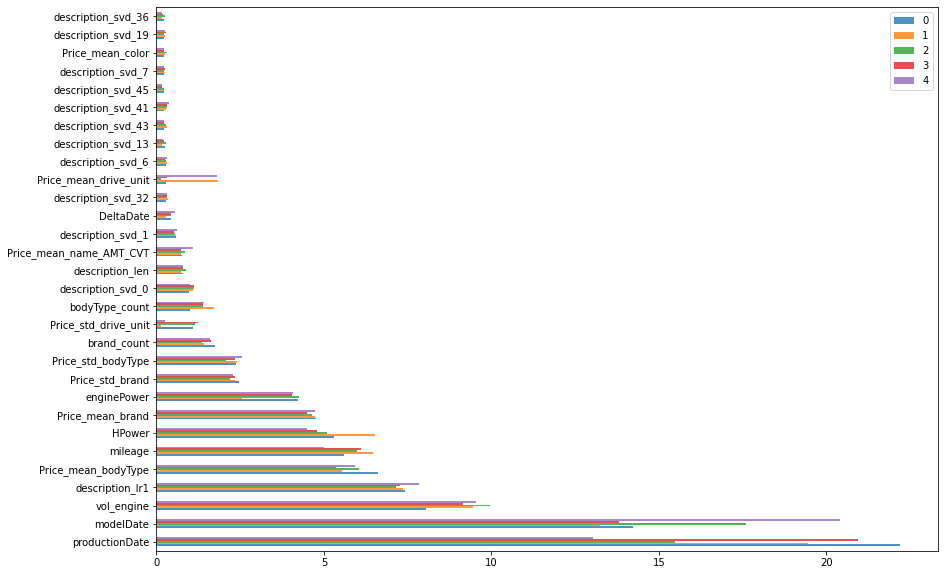

In [112]:
plot_feat_importances(feat_imp, nlargest_ = 30, figsize_ = (14, 10), only_avr = False)

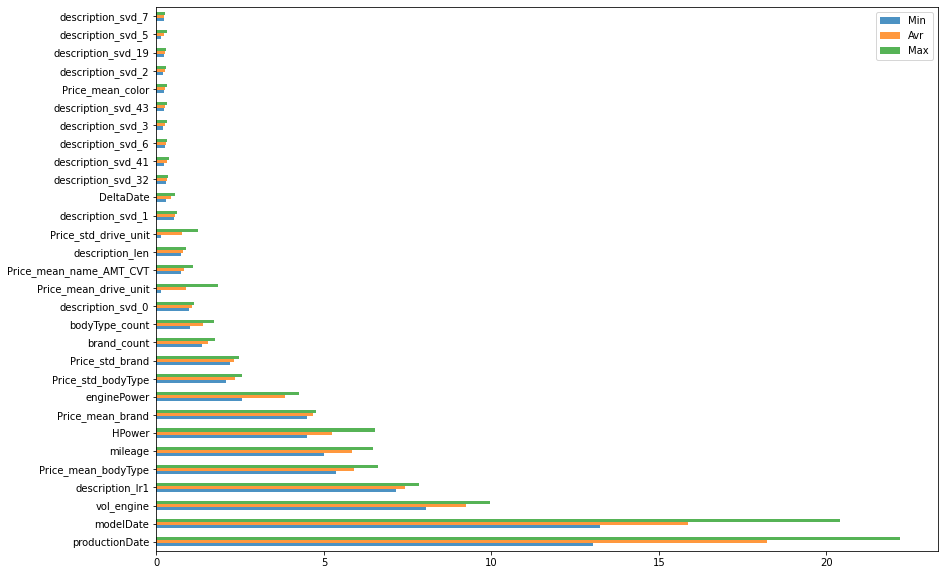

In [113]:
plot_feat_importances(feat_imp, nlargest_ = 30, figsize_ = (14, 10), only_avr = True)

# Генерация признаков (объединение/умножение/отношение)

In [107]:
#функции для генерации и выбора признаков на основе моделирования и расчета метрики
def new_feat_calc_mult(data, model, gen_params, split_params, fit_params, output_params, 
                       col_var, cut_off = 0.0002, delta_ = 0, k_better = 1):
    
    model_result = train_model(data, model, gen_params, split_params, fit_params, output_params)
    y_pred, y_pred_err, feat_imp, metrics_val, metrics_control = model_result
    if isinstance(metrics_val, list):
        metrics_ini = sum(metrics_val)/len(metrics_val)
    else:
        metrics_ini = metrics_val
    print("Метрика базового решения:", metrics_ini)
         
    result_an = pd.DataFrame([])
    result_an[0] = ['baseline', '--------', metrics_ini, 0]
    k = 1
    for i in range(len(col_var)):
        for j in range(i, len(col_var)):
            print(k, col_var[i], col_var[j], end = " ")
            data['temp'] = (data[col_var[i]]+delta_)*(data[col_var[j]]+delta_)
            
            model_result = train_model(data, model, gen_params, split_params, fit_params, output_params)
            y_pred, y_pred_err, feat_imp, metrics_val, metrics_control = model_result
            
            if isinstance(metrics_val, list):
                metrics_i = sum(metrics_val)/len(metrics_val)
            else:
                metrics_i = metrics_val
                      
            delta_metrics = k_better*round(metrics_i - metrics_ini, 4)           
            print(metrics_i, delta_metrics)
            result_an[k] = [col_var[i], col_var[j], metrics_i, delta_metrics]
            k +=1

    result_an.index = ['feat1', 'feat2', 'metrics', 'delta_metrics']
    result_an = result_an.T
    result_dict = result_an[result_an["delta_metrics"]>=cut_off][['feat1','feat2']].to_dict()
    
    return result_dict, result_an

In [108]:
def new_feat_calc_div(data, model, gen_params, split_params, fit_params, output_params, 
                       col_var, cut_off = 0.0002, delta_ = 0, k_better = 1):
    
    model_result = train_model(data, model, gen_params, split_params, fit_params, output_params)
    y_pred, y_pred_err, feat_imp, metrics_val, metrics_control = model_result
    if isinstance(metrics_val, list):
        metrics_ini = sum(metrics_val)/len(metrics_val)
    else:
        metrics_ini = metrics_val
    print("Метрика базового решения:", metrics_ini)
         
    result_an = pd.DataFrame([])
    result_an[0] = ['baseline', '--------', metrics_ini, 0]
    k = 1
    for i in range(len(col_var)):
        for j in range(len(col_var)):
            if i == j: continue
            print(k, col_var[i], col_var[j], end = " ")
            data['temp'] = data[col_var[i]]/(data[col_var[j]]+delta_)
            
            model_result = train_model(data, model, gen_params, split_params, fit_params, output_params)
            y_pred, y_pred_err, feat_imp, metrics_val, metrics_control = model_result
            
            if isinstance(metrics_val, list):
                metrics_i = sum(metrics_val)/len(metrics_val)
            else:
                metrics_i = metrics_val
                      
            delta_metrics = k_better*round(metrics_i - metrics_ini, 4)           
            print(metrics_i, delta_metrics)
            result_an[k] = [col_var[i], col_var[j], metrics_i, delta_metrics]
            k +=1

    result_an.index = ['feat1', 'feat2', 'metrics', 'delta_metrics']
    result_an = result_an.T
    result_dict = result_an[result_an["delta_metrics"]>=cut_off][['feat1','feat2']].to_dict()
    
    return result_dict, result_an

In [109]:
def new_feat_calc_concat(data, model, gen_params, split_params, fit_params, output_params, 
                         col_var, cut_off = 0.0002, k_better = 1):
    
    model_result = train_model(data, model, gen_params, split_params, fit_params, output_params)
    y_pred, y_pred_err, feat_imp, metrics_val, metrics_control = model_result
    if isinstance(metrics_val, list):
        metrics_ini = sum(metrics_val)/len(metrics_val)
    else:
        metrics_ini = metrics_val
    print("Метрика базового решения:", metrics_ini)
         
    result_an = pd.DataFrame([])
    result_an[0] = ['baseline', '--------', metrics_ini, 0]
    k = 1
    for i in range(len(col_var)):
        for j in range(i+1, len(col_var)):
            print(k, col_var[i], col_var[j], end = " ")
            data['temp'] = data[col_var[i]].astype(str) + "_" + data[col_var[j]].astype(str)
            agr_me(data, by = 'temp', col = 'temp', agg_func = 'count')
            data['temp'] = data['temp_count']
            
            model_result = train_model(data, model, gen_params, split_params, fit_params, output_params)
            y_pred, y_pred_err, feat_imp, metrics_val, metrics_control = model_result
            
            if isinstance(metrics_val, list):
                metrics_i = sum(metrics_val)/len(metrics_val)
            else:
                metrics_i = metrics_val
                      
            delta_metrics = k_better*round(metrics_i - metrics_ini, 4)           
            print(metrics_i, delta_metrics)
            result_an[k] = [col_var[i], col_var[j], metrics_i, delta_metrics]
            k +=1

    result_an.index = ['feat1', 'feat2', 'metrics', 'delta_metrics']
    result_an = result_an.T
    result_dict = result_an[result_an["delta_metrics"]>=cut_off][['feat1','feat2']].to_dict()
    
    return result_dict, result_an

In [116]:
split_params = {
    'random_state': RANDOM_STATE,     
    'test_size': 0.15,
    'n_splits' : 1,
    'shuffle': True,
    'stratify': "brand",
}
output_params = {
    'metrics_print': False,
    'feat_importances' : False,
}

data['temp'] = 1
if 'temp' not in col_data:
    col_data.append('temp') 
gen_params = {
    'y_train_name': "Price", 
    'col_data' : col_data,
    'metrics_func' : lambda x,y: round(mape(np.exp(x)-1, np.exp(y)-1), 4),
}
model = CatBoostRegressor(**catbr_params)
col_var = col_data.copy()[:3] #ограничил 3 элементами, что бы сгенерировать пример, считает долго ~ 15ч
result_mult, result_mult_df = new_feat_calc_mult(data, model, gen_params, split_params, fit_params, output_params, 
                                                 col_var, cut_off = 0.0002, delta_ = 0, k_better = -1) 

Метрика базового решения: 11.5453
1 vol_engine vol_engine 11.6795 -0.1342
2 vol_engine description_lr1 11.6593 -0.114
3 vol_engine productionDate 11.6339 -0.0886
4 description_lr1 description_lr1 11.6317 -0.0864
5 description_lr1 productionDate 11.579 -0.0337
6 productionDate productionDate 11.8029 -0.2576


In [117]:
result_mult_df.head()

,feat1,feat2,metrics,delta_metrics
0,baseline,--------,11.5453,0
1,vol_engine,vol_engine,11.6795,-0.1342
2,vol_engine,description_lr1,11.6593,-0.114
3,vol_engine,productionDate,11.6339,-0.0886
4,description_lr1,description_lr1,11.6317,-0.0864


In [119]:
data['temp'] = 1
if 'temp' not in col_data:
    col_data.append('temp')[:3] #ограничил 3 элементами, что бы сгенерировать пример, считает долго ~ 25ч
result_div, result_div_df = new_feat_calc_div(data, model, gen_params, split_params, fit_params, output_params, 
                                              col_var, cut_off = 0.0002, delta_ = 4, k_better = -1) 

Метрика базового решения: 11.5453
1 vol_engine description_lr1 11.6215 -0.0762
2 vol_engine productionDate 11.4845 0.0608
3 description_lr1 vol_engine 11.6748 -0.1295
4 description_lr1 productionDate 11.5022 0.0431
5 productionDate vol_engine 11.5612 -0.0159
6 productionDate description_lr1 11.5848 -0.0395


In [120]:
result_div_df.head()

,feat1,feat2,metrics,delta_metrics
0,baseline,--------,11.5453,0
1,vol_engine,description_lr1,11.6215,-0.0762
2,vol_engine,productionDate,11.4845,0.0608
3,description_lr1,vol_engine,11.6748,-0.1295
4,description_lr1,productionDate,11.5022,0.0431


In [121]:
data['temp'] = 1
if 'temp' not in col_data:
    col_data.append('temp')[:3] #ограничил 3 элементами, что бы сгенерировать пример, считает долго ~ 15ч
result_concat, result_concat_df = new_feat_calc_concat(data, model, gen_params, split_params, fit_params, output_params, 
                                                       col_var, cut_off = 0.0002, k_better = -1)

Метрика базового решения: 11.5453
1 vol_engine description_lr1 11.6993 -0.154
2 vol_engine productionDate 11.5877 -0.0424
3 description_lr1 productionDate 11.688 -0.1427


In [122]:
result_concat_df.head()

,feat1,feat2,metrics,delta_metrics
0,baseline,--------,11.5453,0
1,vol_engine,description_lr1,11.6993,-0.154
2,vol_engine,productionDate,11.5877,-0.0424
3,description_lr1,productionDate,11.688,-0.1427


In [124]:
#Расчет доп. признаков
def cross_feat(data, delta_ = 0):
#----------------------------------Признаки на основе перемножения-(a*b)--------------------------------------------------
    multiply = {'feat1': {89: 'Price_mean_bodyType', 169: 'Price_std_brand', 405: 'Price_mean_vehicleConfiguration', 
                      453: 'Price_std_color', 463: 'Price_mean_color', 475: 'Price_mean_numberOfDoors'}, 
            'feat2': {89: 'name_AMT_CVT_count', 169: 'Price_std_vehicleConfiguration', 405: 'numberOfDoors_count', 
                      453: 'Price_std_name_AMT_CVT', 463: 'Price_mean_numberOfDoors', 475: 'Price_std_vehicleConfiguration'}}

    multiply2 = {'feat1': {127: 'modelDate', 139: 'modelDate', 156: 'productionDate', 177: 'productionDate'}, 
                 'feat2': {127: 'fuelType_count', 139: 'numberOfDoors', 156: 'Price_std_bodyType', 177: 'numberOfDoors_count'}}

    mult_df = pd.DataFrame(multiply).append(pd.DataFrame(multiply2)).reset_index().drop(columns = "index")
    
    dop_col_mult = []
    for i in range(mult_df.shape[0]):
        dop_col_mult.extend([mult_df.feat1[i]+"__M__"+mult_df.feat2[i]]) 
        data[mult_df.feat1[i]+"__M__"+mult_df.feat2[i]] = data[mult_df.feat1[i]]*data[mult_df.feat2[i]]    
        
#-----------------------------------Объединение-категориальных-признаков-(a_b)---------------------------------------------    
    concat = {'feat1': {34: 'PTS', 72: 'brand_count'}, 'feat2': {34: 'wheel_left', 72: 'name_AMT_CVT_count'}}
    concat_df = pd.DataFrame(concat).reset_index().drop(columns = "index")
    
    dop_col_concate = []
    for i in range(concat_df.shape[0]):
        dop_col_concate.extend([concat_df.feat1[i]+"__"+concat_df.feat2[i]])   
        data['temp'] = data[concat_df.feat1[i]].astype(str) + "_" + data[concat_df.feat2[i]].astype(str)
        agr_me(data, by = 'temp', col = 'temp', agg_func = 'count')
        data[concat_df.feat1[i]+"__"+concat_df.feat2[i]] = data['temp_count']
              
    dop_col_concate.extend(dop_col_mult)
    
#---------------------------------------Признаки на основе отношения-(a/b)------------------------------------------------    
    div = {'feat1': {125: 'modelDate', 270: 'Price_mean_brand', 308: 'Price_mean_bodyType', 422: 'Price_std_brand', 
                      536: 'Price_std_bodyType', 802: 'Price_std_fuelType'}, 
            'feat2': {125: 'Price_std_brand', 270: 'modelDate', 308: 'modelDate', 422: 'modelDate', 536: 'modelDate', 
                      802: 'modelDate'}}
    div_df = pd.DataFrame(div).reset_index().drop(columns = "index")
    
    dop_col_div = []
    for i in range(div_df.shape[0]):
        dop_col_div.extend([div_df.feat1[i]+"__D__"+div_df.feat2[i]]) 
        data[div_df.feat1[i]+"__D__"+div_df.feat2[i]] = data[div_df.feat1[i]]/(delta_ + data[div_df.feat2[i]])
        
    dop_col_concate.extend(dop_col_div)
        
    return  dop_col_concate

col_data.extend(cross_feat(data, delta_ = 4))

# Отбор признаков для моделирования (алгоритм ADD DEL)

In [126]:
def add_del_algoritm(data, model, gen_params, split_params, fit_params, output_params, 
                     col_data_base, col_data_all, k_better = 1, iter_max = 300):
    
    if not col_data_base:
        col_data_base.append(col_data_all[0])
        col_data_all.remove(col_data_all[0])
        gen_params['col_data'] = col_data_base.copy()

    model_result = train_model(data, model, gen_params, split_params, fit_params, output_params)
    y_pred, y_pred_err, feat_imp, metrics_val, metrics_control = model_result

    if isinstance(metrics_val, list):
        metrics_base = sum(metrics_val)/len(metrics_val)
    else:
        metrics_base = metrics_val
    print("Метрика базового решения:", metrics_base)    
    
    k = 1 
    while k <= iter_max:
        # ADD part
        print("Starting ADD part")
        for feature_i in col_data_all.copy():
            if  k > iter_max:
                break
            
            col_data_base.append(feature_i)
            gen_params['col_data'] = col_data_base.copy()

            model_result = train_model(data, model, gen_params, split_params, fit_params, output_params)
            y_pred, y_pred_err, feat_imp, metrics_val, metrics_control = model_result
            
            if isinstance(metrics_val, list):
                metrics_i = sum(metrics_val)/len(metrics_val)
            else:
                metrics_i = metrics_val

            delta_metrics = round(k_better*(metrics_i - metrics_base),5)
            if delta_metrics > 0:
                col_data_all.remove(feature_i)
                metrics_base = metrics_i
                print(k," - ", round(metrics_i, 5)," - ", col_data_base)
            else:
                col_data_base.remove(feature_i)
                print(k," - ", round(metrics_i, 5), " -NO ADD- ", feature_i)
            k +=1

        # DEL part
        print("Starting DEL part")
        for feature_i in col_data_base.copy():
            if  k > iter_max:
                break
            
            col_data_base.remove(feature_i)
            gen_params['col_data'] = col_data_base.copy()
            
            model_result = train_model(data, model, gen_params, split_params, fit_params, output_params)
            y_pred, y_pred_err, feat_imp, metrics_val, metrics_control = model_result
            
            if isinstance(metrics_val, list):
                metrics_i = sum(metrics_val)/len(metrics_val)
            else:
                metrics_i = metrics_val
                
            delta_metrics = round(k_better*(metrics_i - metrics_base), 5)
            if delta_metrics > 0:
                col_data_all.append(feature_i)
                metrics_base = metrics_i
                print(k," - ", round(metrics_i, 5)," - ", col_data_base)
            else:
                col_data_base.append(feature_i)
                print(k," - ", round(metrics_i, 5), " -NO DEL- ", feature_i)
            k +=1
            
    return col_data_base

In [127]:
RANDOM_STATE = 999
gen_params = {
    'y_train_name': "Price", 
    'col_data' : col_data,
    'metrics_func' : lambda x,y: round(mape(np.exp(x)-1, np.exp(y)-1), 4),
}
split_params = {
    'random_state': RANDOM_STATE,     
    'test_size': 0,
#     'err_size': 0,
#     'err_feat': "y_pred_v0_err",
    'n_splits' : 5, #10, 5
    'shuffle': True,
    'stratify': "brand",
}
fit_params = { # для catboost
    'eval_set': True,
    'use_best_model': True,
    'plot' : False,
}
catbr_params = {
    'random_seed': RANDOM_STATE, 
    'learning_rate': 0.4, #0.3-оптимальный параметр
    'iterations': 1000, #10000-оптимальный параметр
    'depth': 9, # 9-оптимальный параметр
    'l2_leaf_reg': 1, # 1-оптимальный параметр
#     'eval_metric': 'MAPE',
    'subsample' : 0.75,
    'random_strength': 0.06, 
    'od_type': "Iter", #детектор переобучения catboost
    'od_wait': 100,  # 1500-оптимальный параметр 
    'verbose': False, 
}
output_params = {
    'metrics_print': False,
    'feat_importances' : False,
}

model = CatBoostRegressor(**catbr_params)

col_data_base =  []
col_data_all = col_data.copy()

# Считает безумно долго!!!!!
model = CatBoostRegressor(**catbr_params)
col_data_fin = add_del_algoritm(data, model, gen_params, split_params, fit_params, output_params, 
                                col_data_base, col_data_all, k_better = -1, iter_max = 500)

In [130]:
# Алгоритм ADD_DEL применялся частично
# Найден промежуточный перечень признаков для моделирования
print(col_data_fin)

['data_ind', 'Price_mean_brand__D__modelDate', 'Price_mean_bodyType__D__modelDate', 'vol_engine', 'description_lr1', 'productionDate', 'HPower', 'mileage', 'enginePower', 'modelDate__M__fuelType_count', 'modelDate__D__Price_std_brand', 'Price_std_brand__D__modelDate', 'Price_mean_bodyType', 'Price_std_bodyType__D__modelDate', 'DeltaDate', 'productionDate__M__Price_std_bodyType', 'Price_mean_drive_unit', 'Price_std_brand__M__Price_std_vehicleConfiguration', 'Price_std_brand', 'productionDate__M__numberOfDoors_count', 'description_svd_0', 'Price_mean_brand', 'brand_count', 'description_len', 'bodyType_count', 'Price_std_bodyType', 'modelDate__M__numberOfDoors', 'description_svd_1', 'brand_count__name_AMT_CVT_count', 'Price_std_fuelType__D__modelDate', 'description_svd_32', 'Price_std_drive_unit', 'description_svd_41', 'description_svd_2', 'description_svd_43', 'Price_mean_bodyType__M__name_AMT_CVT_count', 'description_svd_6', 'description_svd_3', 'modelDate', 'description_svd_13', 'descr

# Финальное моделирование

In [60]:
col_data = ['Price_mean_brand__D__modelDate', 'Price_mean_bodyType__D__modelDate', 'vol_engine', 
              'description_lr1', 'productionDate', 'HPower', 'mileage', 'enginePower', 'modelDate__M__fuelType_count', 
              'modelDate__D__Price_std_brand', 'Price_std_brand__D__modelDate', 'Price_mean_bodyType', 
              'Price_std_bodyType__D__modelDate', 'DeltaDate', 'productionDate__M__Price_std_bodyType', 
              'Price_mean_drive_unit', 'Price_std_brand__M__Price_std_vehicleConfiguration', 'Price_std_brand', 
              'productionDate__M__numberOfDoors_count', 'description_svd_0', 'Price_mean_brand', 'brand_count', 
              'description_len', 'bodyType_count', 'Price_std_bodyType', 'modelDate__M__numberOfDoors', 'description_svd_1', 
              'brand_count__name_AMT_CVT_count', 'Price_std_fuelType__D__modelDate', 'description_svd_32', 
              'Price_std_drive_unit', 'description_svd_41', 'description_svd_2', 'description_svd_43', 
              'Price_mean_bodyType__M__name_AMT_CVT_count', 'description_svd_6', 'description_svd_3', 'modelDate', 
              'description_svd_13', 'description_svd_49', 'description_svd_7', 'description_svd_46', 'description_svd_30', 
              'description_svd_45', 'description_svd_42', 'description_svd_4', 
              'Price_mean_vehicleConfiguration__M__numberOfDoors_count', 'description_svd_27', 'description_svd_36', 
              'owner_count', 'description_svd_47', 'description_svd_24', 'description_svd_44', 'description_svd_8', 
              'description_svd_33', 'description_svd_19', 'description_svd_14', 'description_svd_39', 'description_svd_37', 
              'description_svd_38', 'description_svd_5', 'description_svd_40', 'description_svd_10', 
              'Price_std_color__M__Price_std_name_AMT_CVT', 'description_svd_20', 'description_svd_48', 'description_svd_15', 
              'description_svd_16', 'Price_mean_color__M__Price_mean_numberOfDoors', 'description_svd_9', 'description_svd_34', 
              'description_svd_35', 'description_svd_28', 'description_svd_22', 'description_svd_21', 'description_svd_29', 
              'description_svd_12', 'description_svd_31', 'description_svd_26', 'PTS__wheel_left', 'description_svd_25', 
              'description_svd_18', 'description_svd_11', 'description_svd_17', 'description_svd_23', 
              'Price_mean_numberOfDoors__M__Price_std_vehicleConfiguration', 'color_count', 'owner', 'Price_mean_color', 
              'drive_unit_count', 'Price_std_color', 'Price_mean_name_AMT_CVT', 'PTS']

In [52]:
RANDOM_STATE = 900
gen_params = {
    'y_train_name': "Price", 
    'col_data' : col_data,
    'metrics_func' : lambda x,y: round(mape(np.exp(x)-1, np.exp(y)-1), 4),
}
split_params = {
    'random_state': RANDOM_STATE,     
    'test_size': 0,
#     'err_size': 0,
#     'err_feat': "y_pred_v0_err",
    'n_splits' : 1, #10, 5
    'shuffle': True,
#     'stratify': "brand",
}
fit_params = { # для catboost
    'eval_set': True,
    'use_best_model': True,
    'plot' : False,
}
catbr_params = {
    'random_seed': RANDOM_STATE, 
    'learning_rate': 0.3, #0.3-оптимальный параметр
    'iterations': 10000, #10000-оптимальный параметр
    'depth': 9, # 9-оптимальный параметр
    'l2_leaf_reg': 3, # 1-оптимальный параметр
#     'eval_metric': 'MAPE',
    'subsample' : 0.75,
    'random_strength': 0.06, 
    'od_type': "Iter", #детектор переобучения catboost
    'od_wait': 1500,  # 1500-оптимальный параметр 
    'verbose': False, 
}
output_params = {
    'metrics_print': True,
    'feat_importances' : True,
}

model = CatBoostRegressor(**catbr_params)
model_result = train_model(data, model, gen_params, split_params, fit_params, output_params)
y_pred, y_pred_err, feat_imp, metrics_val, metrics_control = model_result

Метрика: 0.4456


In [56]:
data['y_for_subm'] = np.exp(data['y_pred_v0']) - 1 
submission_to_csv(data, subm_ID = "data_ind", round_me = "round", round_coef = 0.1, y_res_name = "y_for_subm", 
                   sub_file = "submission.csv", subm_ID_text = "id", subm_y_text = "price", print_head = True)

   id      price
0   0  1677120.0
1   1  2232070.0
2   2  1549670.0


### Результат на Kaggle 7.3933 - одиночное решение

# Генерация множества решений и усреднение

In [68]:
ver = "_11_"
fit_params['plot'] = False
col_mean = []
for i in range(70):
    catbr_params['subsample'] = random.choice([0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])
    catbr_params['l2_leaf_reg'] = random.choice([0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25])
    catbr_params['random_seed'] = random.randint(10,10000)
    str_ = 'result' + ver + str(i) + "_subs_" + str(catbr_params['subsample'])+ "_l2_" + str(catbr_params['l2_leaf_reg'])+\
            "_rs_" + str(catbr_params['random_seed'])
      
    model = CatBoostRegressor(**catbr_params)
    model_result = train_model(data, model, gen_params, split_params, fit_params, output_params)
    y_pred, y_pred_err, feat_imp, metrics_val, metrics_control = model_result
    
    data[str_] = y_pred
    col_mean.extend([str_])

data['y_pred_v0'] = data[col_mean].mean(axis = 1)

-metrics: mape -test: 0.393 -train: 0.393 -train+test: 0.393


-metrics: mape -test: 0.403 -train: 0.403 -train+test: 0.403


-metrics: mape -test: 0.406 -train: 0.406 -train+test: 0.406


-metrics: mape -test: 0.4 -train: 0.4 -train+test: 0.4


-metrics: mape -test: 0.404 -train: 0.404 -train+test: 0.404


-metrics: mape -test: 0.398 -train: 0.398 -train+test: 0.398


-metrics: mape -test: 0.412 -train: 0.412 -train+test: 0.412


-metrics: mape -test: 0.401 -train: 0.401 -train+test: 0.401


-metrics: mape -test: 0.409 -train: 0.409 -train+test: 0.409


-metrics: mape -test: 0.4 -train: 0.4 -train+test: 0.4


-metrics: mape -test: 0.411 -train: 0.411 -train+test: 0.411


-metrics: mape -test: 0.396 -train: 0.396 -train+test: 0.396


-metrics: mape -test: 0.394 -train: 0.394 -train+test: 0.394


-metrics: mape -test: 0.415 -train: 0.415 -train+test: 0.415


-metrics: mape -test: 0.395 -train: 0.395 -train+test: 0.395


-metrics: mape -test: 0.413 -train: 0.413 -train+test: 0.413


-metrics: mape -test: 0.407 -train: 0.407 -train+test: 0.407


-metrics: mape -test: 0.392 -train: 0.392 -train+test: 0.392


-metrics: mape -test: 0.391 -train: 0.391 -train+test: 0.391


-metrics: mape -test: 0.394 -train: 0.394 -train+test: 0.394


-metrics: mape -test: 0.408 -train: 0.408 -train+test: 0.408


-metrics: mape -test: 0.391 -train: 0.391 -train+test: 0.391


-metrics: mape -test: 0.408 -train: 0.408 -train+test: 0.408


-metrics: mape -test: 0.412 -train: 0.412 -train+test: 0.412


-metrics: mape -test: 0.404 -train: 0.404 -train+test: 0.404


-metrics: mape -test: 0.411 -train: 0.411 -train+test: 0.411


-metrics: mape -test: 0.391 -train: 0.391 -train+test: 0.391


-metrics: mape -test: 0.397 -train: 0.397 -train+test: 0.397


-metrics: mape -test: 0.406 -train: 0.406 -train+test: 0.406


-metrics: mape -test: 0.4 -train: 0.4 -train+test: 0.4


-metrics: mape -test: 0.407 -train: 0.407 -train+test: 0.407


-metrics: mape -test: 0.391 -train: 0.391 -train+test: 0.391


-metrics: mape -test: 0.404 -train: 0.404 -train+test: 0.404


-metrics: mape -test: 0.403 -train: 0.403 -train+test: 0.403


-metrics: mape -test: 0.404 -train: 0.404 -train+test: 0.404


-metrics: mape -test: 0.404 -train: 0.404 -train+test: 0.404


-metrics: mape -test: 0.409 -train: 0.409 -train+test: 0.409


-metrics: mape -test: 0.394 -train: 0.394 -train+test: 0.394


-metrics: mape -test: 0.399 -train: 0.399 -train+test: 0.399


-metrics: mape -test: 0.412 -train: 0.412 -train+test: 0.412


-metrics: mape -test: 0.393 -train: 0.393 -train+test: 0.393


-metrics: mape -test: 0.412 -train: 0.412 -train+test: 0.412


-metrics: mape -test: 0.404 -train: 0.404 -train+test: 0.404


-metrics: mape -test: 0.403 -train: 0.403 -train+test: 0.403


-metrics: mape -test: 0.389 -train: 0.389 -train+test: 0.389


-metrics: mape -test: 0.405 -train: 0.405 -train+test: 0.405


-metrics: mape -test: 0.41 -train: 0.41 -train+test: 0.41


-metrics: mape -test: 0.405 -train: 0.405 -train+test: 0.405


-metrics: mape -test: 0.401 -train: 0.401 -train+test: 0.401


-metrics: mape -test: 0.399 -train: 0.399 -train+test: 0.399


-metrics: mape -test: 0.408 -train: 0.408 -train+test: 0.408


-metrics: mape -test: 0.404 -train: 0.404 -train+test: 0.404


-metrics: mape -test: 0.401 -train: 0.401 -train+test: 0.401


-metrics: mape -test: 0.405 -train: 0.405 -train+test: 0.405


-metrics: mape -test: 0.41 -train: 0.41 -train+test: 0.41


-metrics: mape -test: 0.392 -train: 0.392 -train+test: 0.392


-metrics: mape -test: 0.404 -train: 0.404 -train+test: 0.404


-metrics: mape -test: 0.396 -train: 0.396 -train+test: 0.396


-metrics: mape -test: 0.419 -train: 0.419 -train+test: 0.419


-metrics: mape -test: 0.409 -train: 0.409 -train+test: 0.409


-metrics: mape -test: 0.413 -train: 0.413 -train+test: 0.413


-metrics: mape -test: 0.41 -train: 0.41 -train+test: 0.41


-metrics: mape -test: 0.41 -train: 0.41 -train+test: 0.41


-metrics: mape -test: 0.401 -train: 0.401 -train+test: 0.401


-metrics: mape -test: 0.412 -train: 0.412 -train+test: 0.412


-metrics: mape -test: 0.395 -train: 0.395 -train+test: 0.395


-metrics: mape -test: 0.389 -train: 0.389 -train+test: 0.389


-metrics: mape -test: 0.391 -train: 0.391 -train+test: 0.391


-metrics: mape -test: 0.4 -train: 0.4 -train+test: 0.4


-metrics: mape -test: 0.409 -train: 0.409 -train+test: 0.409


In [65]:
col_list = filtr_list(data.columns, "result", include = True)
print(len(col_list))
print(col_list)

128
['result_1_0', 'result_1_1', 'result_1_2', 'result_1_3', 'result_1_4', 'result_2_0', 'result_2_1', 'result_2_2', 'result_2_3', 'result_2_4', 'result_3_0', 'result_3_1', 'result_3_2', 'result_3_3', 'result_3_4', 'result_4_0', 'result_4_1', 'result_4_2', 'result_4_3', 'result_4_4', 'result_5_0', 'result_5_1', 'result_5_2', 'result_5_3', 'result_5_4', 'result_6_0', 'result_6_1', 'result_6_2', 'result_6_3', 'result_6_4', 'result_7_0', 'result_7_1', 'result_7_2', 'result_7_3', 'result_7_4', 'result_7_5', 'result_7_6', 'result_8_0', 'result_8_1', 'result_8_2', 'result_8_3', 'result_8_4', 'result_8_5', 'result_8_6', 'result_9_0', 'result_9_1', 'result_9_2', 'result_9_3', 'result_9_4', 'result_9_5', 'result_9_6', 'result_10_0', 'result_10_1', 'result_10_2', 'result_10_3', 'result_10_4', 'result_10_5', 'result_10_6', 'result_11_0_subs_0.9_l2_0.9_rs_6138', 'result_11_1_subs_0.8_l2_1.05_rs_9180', 'result_11_2_subs_0.7_l2_0.9_rs_7325', 'result_11_3_subs_0.9_l2_1.25_rs_613', 'result_11_4_subs_0

In [66]:
data['y_pred_v0'] = data[col_list].mean(axis = 1)
data['y_for_subm'] = np.exp(data['y_pred_v0']) - 1 
submission_to_csv(data, subm_ID = "data_ind", round_me = "round", round_coef = 0.1, y_res_name = "y_for_subm", 
                   sub_file = "submission.csv", subm_ID_text = "id", subm_y_text = "price", print_head = True)

   id      price
0   0  1676400.0
1   1  2236740.0
2   2  1548470.0


### Результат на Kaggle 6.76589 - простое среднее 128 решений

In [92]:
#немного отфильтруем по качеству
dt = data.query('sample == 1')
col_mean = []
krit = 0.395
for i in col_list:
    a = mape(np.exp(dt["Price"]),np.exp(dt[i]))
    if a < krit :
        col_mean.extend([i])
#     print(i, a, cond_)

print(len(col_mean))
print(col_mean)

23
['result_9_0', 'result_9_1', 'result_9_2', 'result_9_3', 'result_9_4', 'result_9_5', 'result_9_6', 'result_11_0_subs_0.9_l2_0.9_rs_6138', 'result_11_12_subs_0.9_l2_0.95_rs_8828', 'result_11_14_subs_0.85_l2_0.85_rs_4119', 'result_11_17_subs_0.95_l2_1.0_rs_1276', 'result_11_18_subs_0.95_l2_0.95_rs_8954', 'result_11_19_subs_0.95_l2_1.1_rs_6709', 'result_11_21_subs_0.9_l2_0.85_rs_5915', 'result_11_26_subs_0.95_l2_0.95_rs_316', 'result_11_31_subs_0.95_l2_0.9_rs_8249', 'result_11_37_subs_0.95_l2_1.1_rs_3692', 'result_11_40_subs_0.95_l2_1.0_rs_820', 'result_11_44_subs_0.95_l2_0.85_rs_7328', 'result_11_55_subs_0.9_l2_0.85_rs_2486', 'result_11_65_subs_0.9_l2_1.0_rs_4686', 'result_11_66_subs_0.95_l2_0.85_rs_3622', 'result_11_67_subs_0.9_l2_0.85_rs_1066']


In [93]:
data['y_pred_v0'] = data[col_mean].mean(axis = 1)
data['y_for_subm'] = np.exp(data['y_pred_v0']) - 1 
submission_to_csv(data, subm_ID = "data_ind", round_me = "round", round_coef = 0.1, y_res_name = "y_for_subm", 
                   sub_file = "submission.csv", subm_ID_text = "id", subm_y_text = "price", print_head = True)

   id      price
0   0  1678010.0
1   1  2236300.0
2   2  1550610.0


### Результат на Kaggle 6.7555 - простое среднее 23 отобранных решений

![title](subm.jpg)